# Set-up example

In [1]:
import numpy as np 
import scipy.stats as sp 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random 
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.stats.power
from sklearn.utils import resample
from tqdm.notebook import trange

In [2]:
df = sns.load_dataset('diamonds')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


# 1. Statistical Estimations

## 1.1 Estimates of location

In [3]:
[np.mean(df.x), 
 np.average(df.x, weights = df.carat), 
 np.median(df.x), 
 sp.trim_mean(df.x, 0.1)]

[5.731157211716722, 6.380923712740938, 5.7, 5.660075778642937]

## 1.2 Estimates of variability

In [4]:
[np.std(df.x),
 np.quantile(df.x, 0.25)]

[1.1217503485171316, 4.71]

# 2. Correlation

## 2.1 Correlation plot

In [5]:
df[['x','y','z']].corr()

,x,y,z
x,1.000000,0.974701,0.970772
y,0.974701,1.000000,0.952006
z,0.970772,0.952006,1.000000


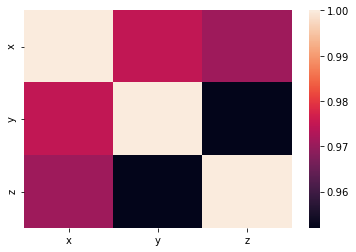

In [6]:
sns.heatmap(df[['x','y','z']].corr())

# 3. Sampling 

In [7]:
df.sample(n = 100)

,carat,cut,color,clarity,depth,table,price,x,y,z
38285,0.28,Very Good,F,VS1,60.8,58.0,487,4.24,4.28,2.59
40450,0.51,Very Good,I,VS2,63.3,56.0,1140,5.02,5.06,3.19
44198,0.51,Ideal,D,SI1,62.4,57.0,1569,5.09,5.13,3.19
25721,2.03,Ideal,G,SI1,62.0,57.0,14637,8.10,8.05,5.01
31263,0.32,Premium,E,SI2,61.7,60.0,449,4.38,4.41,2.71
...,...,...,...,...,...,...,...,...,...,...
30880,0.33,Premium,E,SI1,60.2,58.0,743,4.55,4.49,2.72
20819,1.13,Ideal,G,VVS1,61.2,57.0,9049,6.65,6.72,4.09
31341,0.43,Very Good,D,SI1,62.9,56.0,760,4.78,4.83,3.02
98,0.73,Very Good,E,SI1,61.6,59.0,2760,5.77,5.78,3.56


In [8]:
df.x.mean()

5.731157211716722

## 3.1 Sampling distribution of statistics

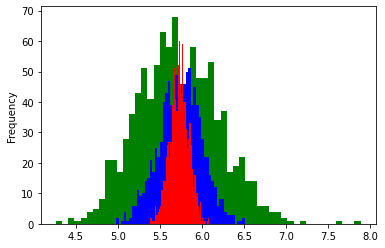

In [9]:
pd.Series([df.x.sample(n = 5).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'green')
pd.Series([df.x.sample(n = 20).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'blue')
pd.Series([df.x.sample(n = 100).mean() for _ in range(1000)]).plot.hist(bins = 50, color = 'red')

## 3.2 Standard error 

In [10]:
sp.sem(df.x)

0.0048299737209106675

# 4. Bootstrap

In [11]:
results = []
for _ in trange(1000):
    sample = resample(df.x)
    results.append(sample.median())
    
results = pd.Series(results)

print('Bootstrap Statistics:')
print(f'original: {df.x.median()}')
print(f'bias: {results.mean() - df.x.median()}')
print(f'std.error: {results.std()}')
print(f'95% confidence interval: {results.quantile(0.025)} ~ {results.quantile(1 - 0.025)}')


Bootstrap Statistics:
original: 5.7
bias: -0.003754999999999953
std.error: 0.005697142479562145
95% confidence interval: 5.69 ~ 5.71


# 5. Distributions

## 5.1 Normal distribution

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

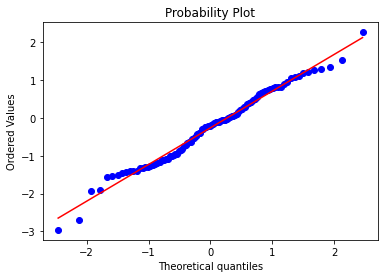

In [12]:
norm_sample = sp.norm.rvs(size = 100)
sp.probplot(norm_sample, plot = plt)

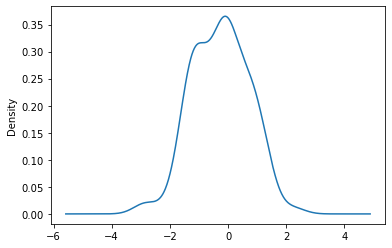

In [13]:
pd.Series(norm_sample).plot.density()

## 5.2 Long-tailed distribution

## 5.3 Student's t-distribution

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

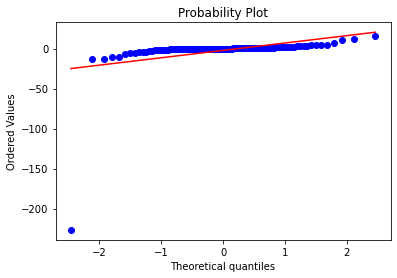

In [14]:
t_sample = sp.t.rvs(df = 1, size = 100)
sp.probplot(t_sample, plot = plt)

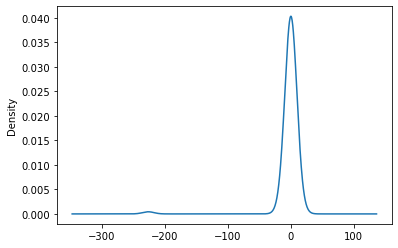

In [15]:
pd.Series(t_sample).plot.density()

## 5.4 Binomial distribution

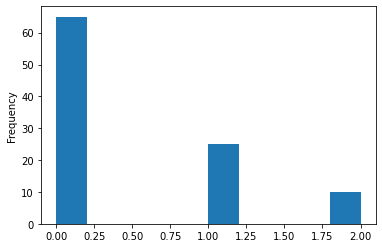

In [16]:
binomial_sample = sp.binom.rvs(n = 5, p = 0.1, size = 100)
pd.Series(binomial_sample).plot.hist()

In [17]:
sp.binom.pmf(k = 2, n = 5, p = 0.1)

0.0729

In [18]:
sp.binom.cdf(k = 2, n = 5, p = 0.1)

0.99144

## 5.5 Chi-square distribution

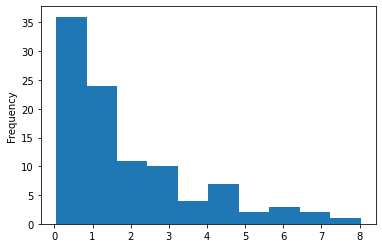

In [19]:
chi2_sample = sp.chi2.rvs(df = 2, size = 100)
pd.Series(chi2_sample).plot.hist()

## 5.6 F-distribution

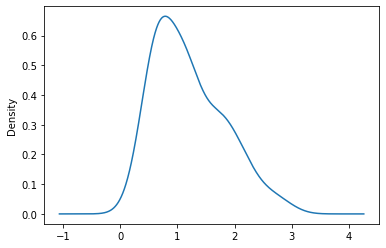

In [20]:
f_sample = sp.f.rvs(dfn = 20, dfd = 20, size = 100)
pd.Series(f_sample).plot.density()

## 5.7 Poisson distributions

### Poisson

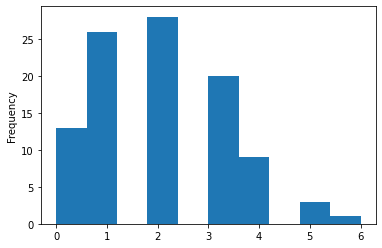

In [21]:
poisson_sample = sp.poisson.rvs(mu = 2, size = 100)
pd.Series(poisson_sample).plot.hist()

### Exponential

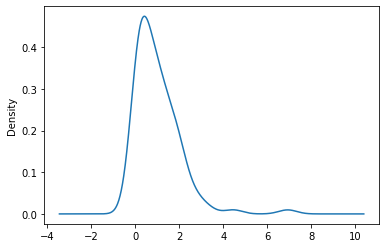

In [22]:
expon_sample = sp.expon.rvs(size = 100)
pd.Series(expon_sample).plot.density()

### Weibull

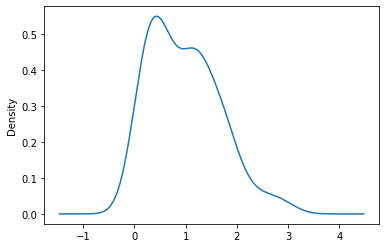

In [23]:
weibull_sample = sp.weibull_min.rvs(c = 1.5, size = 100)
pd.Series(weibull_sample).plot.density()

# 6. Statistical Experiments and Significance Testing

https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

## 6.1 Hypothesis tests

## 6.2 Resampling

### Permutation

In [24]:
df = pd.DataFrame(
    {'Page':['Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page A', 'Page A', 'Page A', 'Page A', 'Page A'],
    'Time':[0.21, 2.53, 0.35, 0.71, 0.67, 0.85, 2.11, 2.46, 1.32, 1.49, 0.68,
            0.75, 3.21, 3.33, 1.47, 1.87, 0.95, 1.26, 0.45, 0.48, 1.18, 1.47,
            3.42, 3.57, 1.97, 2.23, 0.39, 0.43, 0.65, 0.87, 1.73, 0.74, 0.86,
            1.18, 2.06, 0.93]})
df

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67
5,Page B,0.85
6,Page A,2.11
7,Page B,2.46
8,Page A,1.32
9,Page B,1.49


In [25]:
df.Page.value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

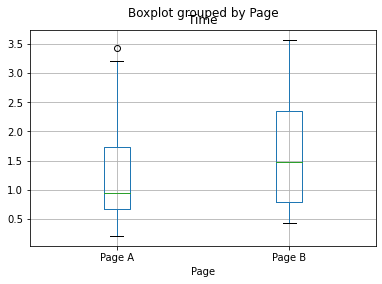

In [26]:
df.boxplot(by = 'Page', column = 'Time')

In [27]:
mean_a = df[df.Page == 'Page A'].Time.mean()
mean_b = df[df.Page == 'Page B'].Time.mean()
mean_a, mean_b

(1.2633333333333332, 1.62)

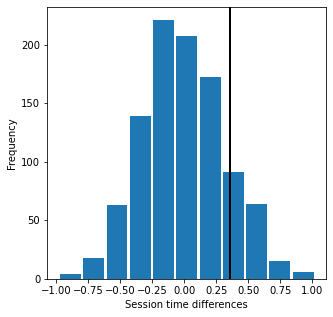

In [28]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(population = range(n), k = nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = df[df.Page == 'Page A'].shape[0]
nB = df[df.Page == 'Page B'].shape[0]

perm_diffs = [perm_fun(df.Time, nA, nB) for _ in trange(1000)]

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = mean_b - mean_a, color = 'black', lw = 2)
ax.set_xlabel('Session time differences')
ax.set_ylabel('Frequency')
plt.show()

In [29]:
print(f'p-value: {np.mean(perm_diffs > mean_b - mean_a)}')

p-value: 0.138


## 6.3 Statistical significance and p-values

Outcome | Price A | Price B

Conversion | 200 | 182

No conversion | 23,539 | 22,406

In [30]:
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
obs_pct_diff

0.03675791182059275

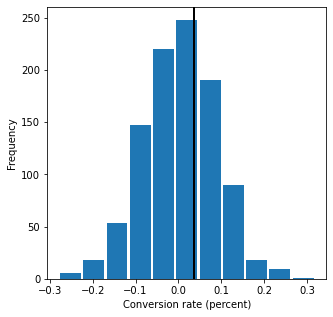

In [31]:
conversion = [0] * 45945
conversion.extend([1] * 382)
df = pd.Series(conversion)

perm_diffs = [100 * perm_fun(df, 23739, 22588) for _ in trange(1000)]

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = obs_pct_diff, color = 'black', lw = 2)
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [32]:
print(f'p-value: {np.mean(np.array(perm_diffs) > obs_pct_diff)}')

p-value: 0.348


In [33]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = sp.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## 6.4 t-tests

In [34]:
df = pd.DataFrame(
    {'Page':['Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page B', 'Page A', 'Page B', 'Page A', 'Page B',
             'Page A', 'Page A', 'Page A', 'Page A', 'Page A', 'Page A'],
    'Time':[0.21, 2.53, 0.35, 0.71, 0.67, 0.85, 2.11, 2.46, 1.32, 1.49, 0.68,
            0.75, 3.21, 3.33, 1.47, 1.87, 0.95, 1.26, 0.45, 0.48, 1.18, 1.47,
            3.42, 3.57, 1.97, 2.23, 0.39, 0.43, 0.65, 0.87, 1.73, 0.74, 0.86,
            1.18, 2.06, 0.93]})
df

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67
5,Page B,0.85
6,Page A,2.11
7,Page B,2.46
8,Page A,1.32
9,Page B,1.49


In [35]:
res = sp.ttest_ind(df[df.Page == 'Page A'].Time,
                   df[df.Page == 'Page B'].Time,
                   equal_var = False)
print(f'formula p-value for single sided test: {res.pvalue / 2:.4f}')

formula p-value for single sided test: 0.1408


## 6.5 Multiple testing

## 6.6 Degrees of freedom

## 6.7 ANOVA

In [36]:
df = pd.DataFrame({'Page':['Page 1','Page 2','Page 3','Page 4'] * 5,
                   'Time':[164,178,175,155,172,191,193,166,177,182,171,164,156,185,163,170,195,177,176,168]})
df

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [37]:
observed_variance = df.groupby('Page').mean().var()[0]
print(f"Observed means: {df.groupby('Page').mean().values.ravel()}")
print(f'Variance: {observed_variance:.2f}')

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.43


In [38]:
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(df) for _ in trange(3000)]
print(f'Pr(Prob): {np.mean(np.array(perm_variance) > observed_variance):.2f}')


Pr(Prob): 0.08


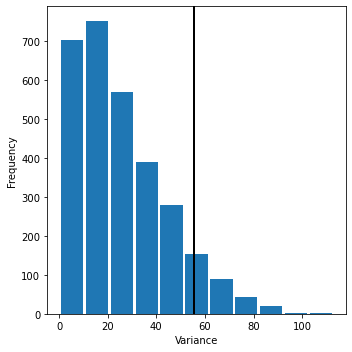

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### F-statistics

In [40]:
model = smf.ols('Time ~ Page', data = df).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


### Two-way ANOVA

## 6.8 Chi-square test

In [41]:
df = pd.DataFrame({'Headline':['A','A','B','B','C','C'],
                   'Click':['Click','No-click','Click','No-click','Click','No-click'],
                   'Rate':[14,986,8,992,12,988]})
df

,Headline,Click,Rate
0,A,Click,14
1,A,No-click,986
2,B,Click,8
3,B,No-click,992
4,C,Click,12
5,C,No-click,988


In [42]:
df_pivot = df.pivot(index = 'Click', columns = 'Headline', values = 'Rate')
df_pivot

Headline,A,B,C
Click,,,
Click,14,8,12
No-click,986,992,988


In [43]:
box = [1] * (14+8+12)
box.extend([0] * (986+992+988))
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
    return np.sum(pearson_residuals)

expected_clicks = (14+8+12) / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(df_pivot.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in trange(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)

print(f'Observed chi2: {chi2observed:.2f}')
print(f'Resampled p-value: {resampled_p_value:.2f}')


Observed chi2: 1.67
Resampled p-value: 0.48


In [44]:
chisq, p_value, df, expected = sp.chi2_contingency(df_pivot)
print(f'Observed chi2: {chi2observed:.2f}')
print(f'p-value: {p_value:.2f}')

Observed chi2: 1.67
p-value: 0.43


## 6.9 Multi-arm bandit algorithm

## 6.10 Power and sample size

In [45]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
result = sm.stats.TTestIndPower().solve_power(effect_size = effect_size,
                                              alpha = 0.05,
                                              power = 0.8,
                                              alternative = 'larger')
print(f'Sample Size: {result:.2f}')

Sample Size: 116602.39
